In [162]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [163]:
import pandas as pd
import numpy as np

dtypes = {'country':'int64','device_id':'int64','platform':'category','ref_type_id':'category','source_id':'category'}
cols = ['date','device_id','platform','ref_type_id','source_id']
auctions = pd.read_csv(r'C:\Users\Matias\Documents\UBA\Datos\auctions.csv.gzip', usecols = cols, compression = 'gzip', dtype = dtypes)

In [164]:
def get_most_active(df,percentage):
    return df.nlargest(math.ceil(auctions['device_id'].nunique()*percentage),'auction_count_value')

def get_least_active(df,percentage):
    return df.nsmallest(math.floor(auctions['device_id'].nunique()*percentage),'auction_count_value')

def get_auctions_from_list(dlist,field):
    return auctions[auctions[field].isin(dlist)]

def new_comparison(dfs_to_compare,criteria,index_names):
    df = pd.DataFrame()
    j = 0
    for i in index_names:
        df[i] = dfs_to_compare[j][criteria]
        j = j +1
    return df

In [165]:
auctions['date'] = pd.to_datetime(auctions['date'])
auctions['hour'] = auctions['date'].apply(lambda x: x.hour)
auctions['hour'] = auctions['hour'].astype('int8')

auctions['day'] = auctions['date'].apply(lambda x: x.day)
auctions['day'] = auctions['day'].astype('int8')
auctions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19571319 entries, 0 to 19571318
Data columns (total 7 columns):
date           datetime64[ns]
device_id      int64
platform       category
ref_type_id    category
source_id      category
hour           int8
day            int8
dtypes: category(3), datetime64[ns](1), int64(1), int8(2)
memory usage: 392.0 MB


In [166]:
auctions.head()

,date,device_id,platform,ref_type_id,source_id,hour,day
0,2019-03-11 14:18:33.290763,6059599345986491085,1,1,0,14,11
1,2019-03-11 14:18:34.440157,1115994996230693426,1,1,0,14,11
2,2019-03-11 14:18:35.862360,7463856250762200923,1,1,0,14,11
3,2019-03-11 14:18:36.167163,7829815350267792040,1,1,0,14,11
4,2019-03-11 14:18:37.728590,1448534231953777480,1,1,0,14,11


In [167]:
auctions['auction_count_value'] = 1
auctions['auction_count_value'] = auctions['auction_count_value'].astype('int32')

In [168]:
byDevice = auctions.groupby('device_id').agg({'auction_count_value':'sum'})

Text(0, 0.5, 'auctions')

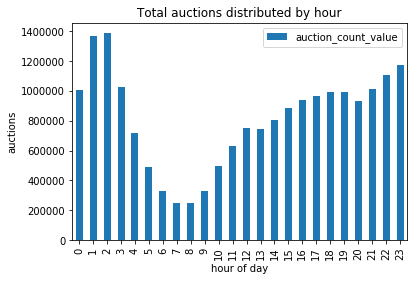

In [169]:
ax = auctions.groupby('hour').agg({'auction_count_value':'sum'}).plot.bar(title = 'Total auctions distributed by hour')
ax.set_xlabel("hour of day")
ax.set_ylabel("auctions")

In [170]:
top10PercentDevices = get_most_active(byDevice,.1)
top10PercentDevices = get_auctions_from_list(top10PercentDevices.index.tolist(),'device_id')

bot90PercentDevices = get_least_active(byDevice,.9)
bot90PercentDevices = get_auctions_from_list(bot90PercentDevices.index.tolist(),'device_id')

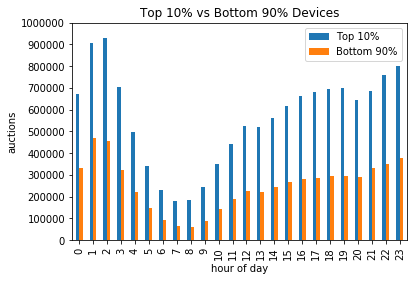

In [171]:
bot = bot90PercentDevices.groupby('hour').agg({'auction_count_value':'sum'})
top = top10PercentDevices.groupby('hour').agg({'auction_count_value':'sum'})
comparison = new_comparison([top,bot],'auction_count_value',['Top 10%','Bottom 90%'])

yt = [i*100000 for i in range(0,11)]
ax = comparison.plot.bar(title = 'Top 10% vs Bottom 90% Devices (Avg)', yticks = yt)
ax.set_xlabel("hour of day")
ax.set_ylabel("auctions")

#
top = None
bot = None
comparison = None

In [172]:
totalByDay = auctions.groupby('day').agg({'auction_count_value':'sum'})

In [173]:
daysOrdered = ['Tue','Wed','Thu','Fri','Sat','Sun','Mon']

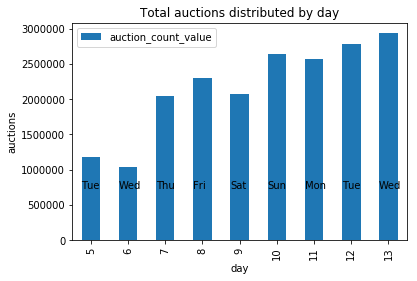

In [174]:
ax = totalByDay.plot.bar(title = 'Total auctions distributed by day')
ax.set_xlabel("day")
ax.set_ylabel("auctions")
i= 0
for p in ax.patches:
    ax.annotate(s = daysOrdered[i%len(daysOrdered)], xy = (p.get_x(), totalByDay['auction_count_value'].max()/4))
    i = i + 1
#5 Martes

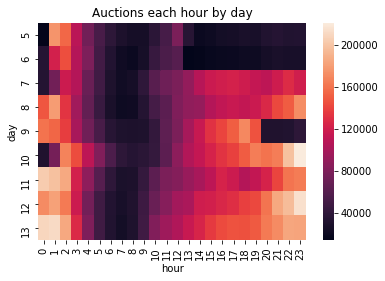

In [184]:
byHoursDays = auctions.groupby(['day','hour']).agg({'auction_count_value':'sum'}).unstack()
byHoursDays.columns = byHoursDays.columns.get_level_values(1)
ax = plt.axes()
ax.set_title('Auctions each hour by day')
sns.heatmap(byHoursDays,ax = ax)

In [175]:
botPercentDevices = bot90PercentDevices.groupby('day').agg({'auction_count_value':'sum'})
topPercentDevices = top10PercentDevices.groupby('day').agg({'auction_count_value':'sum'})

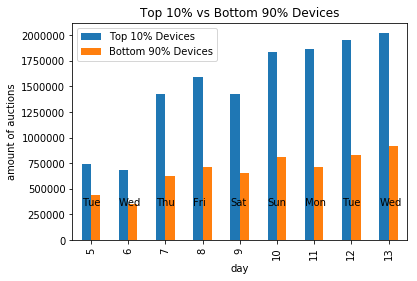

In [176]:
comparison = new_comparison([topPercentDevices,botPercentDevices],'auction_count_value',['Top 10% Devices','Bottom 90% Devices'])

ax = comparison.plot.bar(title = 'Top 10% vs Bottom 90% Devices')
ax.set_xlabel("day")
ax.set_ylabel("amount of auctions")
i= 0
j = 0
for p in ax.patches:
    if i<9:
        ax.annotate(s = daysOrdered[j%len(daysOrdered)], xy = (p.get_x(), topPercentDevices['auction_count_value'].max()/6))
        j = j+1
    i = i + 1

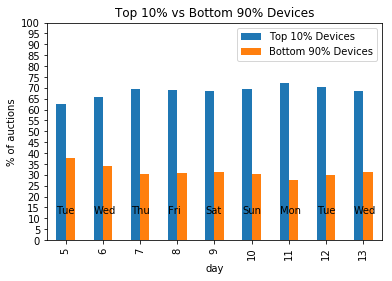

In [177]:
botPercentDevices = bot90PercentDevices.groupby('day').agg({'auction_count_value':'sum'})
topPercentDevices = top10PercentDevices.groupby('day').agg({'auction_count_value':'sum'})

topPercentDevices = topPercentDevices.div(totalByDay, level='day') * 100
botPercentDevices = botPercentDevices.div(totalByDay, level='day') * 100
comparison = new_comparison([topPercentDevices,botPercentDevices],'auction_count_value',['Top 10% Devices','Bottom 90% Devices'])

yt = [i*5 for i in range(0,21)]
ax = comparison.plot.bar(title = 'Top 10% vs Bottom 90% Devices', yticks = yt)
ax.set_xlabel("day")
ax.set_ylabel("% of auctions")
i= 0
j = 0
for p in ax.patches:
    if i<9:
        ax.annotate(s = daysOrdered[j%len(daysOrdered)], xy = (p.get_x(), topPercentDevices['auction_count_value'].max()/6))
        j = j+1
    i = i + 1

In [178]:
comparison

,Top 10% Devices,Bottom 90% Devices
day,,
5,62.396683,37.586656
6,65.947704,34.037097
7,69.497490,30.507198
8,69.205541,30.813391
9,68.462155,31.513792
10,69.416281,30.577957
11,72.360341,27.647698
12,70.267742,29.734488
13,68.763666,31.243276


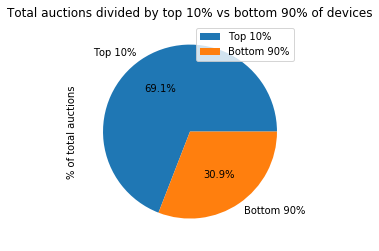

In [179]:
botPercentDevices = bot90PercentDevices.groupby('day').agg({'auction_count_value':'sum'})
topPercentDevices = top10PercentDevices.groupby('day').agg({'auction_count_value':'sum'})
total = pd.DataFrame({'% of total auctions':[topPercentDevices['auction_count_value'].sum(),botPercentDevices['auction_count_value'].sum()]},
                    index = ['Top 10%','Bottom 90%'])
total.plot.pie(y = '% of total auctions',autopct='%1.1f%%',title = 'Total auctions divided by top 10% vs bottom 90% of devices')

In [180]:
#10% of the devices hold almost 70% of the auctions

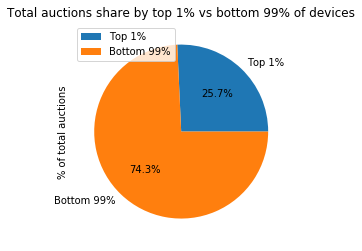

In [181]:
top1PercentDevices = get_most_active(byDevice,.01)
top1PercentDevices = get_auctions_from_list(top1PercentDevices.index.tolist(),'device_id')
bot99PercentDevices = get_least_active(byDevice,.99)
bot99PercentDevices = get_auctions_from_list(bot99PercentDevices.index.tolist(),'device_id')

botPercentDevices = bot99PercentDevices.groupby('day').agg({'auction_count_value':'sum'})
topPercentDevices = top1PercentDevices.groupby('day').agg({'auction_count_value':'sum'})

total = pd.DataFrame({'% of total auctions':[topPercentDevices['auction_count_value'].sum(),botPercentDevices['auction_count_value'].sum()]},
                    index = ['Top 1%','Bottom 99%'])
total.plot.pie(y = '% of total auctions',autopct='%1.1f%%',title = 'Total auctions share by top 1% vs bottom 99% of devices')

In [182]:
# 1% of the devices hold almost 25% of the auctions

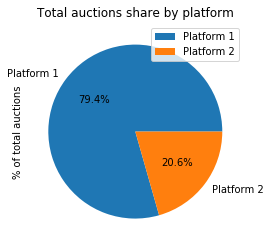

In [183]:
byPlatform = auctions.groupby('platform').agg({'auction_count_value':'sum'})

total = pd.DataFrame({'% of total auctions':[byPlatform.iloc[0]['auction_count_value'],byPlatform.iloc[1]['auction_count_value']]},
                   index = ['Platform 1','Platform 2'])
total.plot.pie(y = '% of total auctions',autopct='%1.1f%%',title = 'Total auctions share by platform')